In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt


# odszumianie sygnału

df = pd.read_csv('../../data/partially processed/resampled_data_no_outliers.csv')
df.drop(columns=['outlier_label'], inplace=True)
df['epoch (ms)'] = pd.to_datetime(df['epoch (ms)'])
df.set_index('epoch (ms)', inplace=True)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)



# calate set duration
for i in df["set"].unique():
    duration = df[df["set"] == i].index[-1] - df[df["set"] == i].index[0]
    df.loc[df["set"] == i, "duration"] = duration.seconds
    
duration_data = df.groupby("category")["duration"].mean()
    




In [2]:
df_filtered = df.copy()
columns_to_check = ["acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z"]

for cat, duration in duration_data.items():
    subset = df_filtered[df_filtered["category"] == cat]
    if len(subset) == 0:
        continue
    if cat == "heavy":
        fs = len(subset) / (duration/5)
    if cat == "medium":
        fs = len(subset) / (duration/10)
    
    cutoff = fs / 5.0
    for col in columns_to_check:
        filtered = butter_lowpass_filter(subset[col].values, cutoff, fs)
        df_filtered.loc[subset.index, col] = filtered


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

osdf = df[df["set"] == 20]
fsdf = df_filtered[df_filtered["set"] == 20]

plt.figure(figsize=(20, 10))
plt.plot(osdf["acc_y"], label="original")
plt.plot(fsdf["acc_y"], label="filtered")
plt.legend()
plt.show()




In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Prepare the data
X = df[columns_to_check]
y = df['label']

X_filtered = df_filtered[columns_to_check]
y_filtered = df_filtered['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42)

# Train the Random Forest classifier on the original data
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Train the Random Forest classifier on the filtered data
clf_filtered = RandomForestClassifier(n_estimators=100, random_state=42)
clf_filtered.fit(X_train_filtered, y_train_filtered)

# Make predictions
y_pred = clf.predict(X_test)
y_pred_filtered = clf_filtered.predict(X_test_filtered)

# Print classification reports
print("Classification report for original data:")
print(classification_report(y_test, y_pred))

print("Classification report for filtered data:")
print(classification_report(y_test_filtered, y_pred_filtered))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt


# odszumianie sygnału

df = pd.read_csv('../../data/partially processed/resampled_data_no_outliers.csv')
df.drop(columns=['outlier_label'], inplace=True)
df['epoch (ms)'] = pd.to_datetime(df['epoch (ms)'])
df.set_index('epoch (ms)', inplace=True)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)



def calculate_set_duration(df):
    for i in df["set"].unique():
        duration = df[df["set"] == i].index[-1] - df[df["set"] == i].index[0]
        df.loc[df["set"] == i, "duration"] = duration.seconds
    
    duration_data = df.groupby("category")["duration"].mean()
    return duration_data

def apply_low_pass_filter(df, duration_data):
    df_filtered = df.copy()
    columns_to_check = ["acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z"]

    for cat, duration in duration_data.items():
        subset = df_filtered[df_filtered["category"] == cat]
        if len(subset) == 0:
            continue
        if cat == "heavy":
            fs = len(subset) / (duration / 5)
        if cat == "medium":
            fs = len(subset) / (duration / 10)

        cutoff = fs / 5.0
        for col in columns_to_check:
            filtered = butter_lowpass_filter(subset[col].values, cutoff, fs)
            df_filtered.loc[subset.index, col] = filtered

    return df_filtered

# Example usage:
duration_data = calculate_set_duration(df)
df_filtered = apply_low_pass_filter(df, duration_data)

    




In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# filepath: /Users/stanislaw/Docs/inzynierka/inzynierka/data/partially processed/filtered_data_sample.csv
df = pd.read_csv("../../data/partially processed/filtered_data.csv")

# Select numeric columns for PCA
numeric_cols = ["acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z"]
X = df[numeric_cols].values

# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA with 3 principal components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Print explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Optional: plot explained variance
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Scree Plot')
plt.show()

df["pca_1"] = X_pca[:,0]
df["pca_2"] = X_pca[:,1]
df["pca_3"] = X_pca[:,2]



In [ ]:

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


numeric_cols = ["acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z"]
X = df[numeric_cols].values
y = df["label"].values  # Make sure 'label' exists in df

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lda = LinearDiscriminantAnalysis(n_components=3)
X_lda = lda.fit_transform(X_scaled, y)

print("Explained Variance Ratio:", lda.explained_variance_ratio_)

plt.plot(range(1, len(lda.explained_variance_ratio_)+1), lda.explained_variance_ratio_, marker='o')
plt.xlabel('Linear Discriminant')
plt.ylabel('Explained Variance Ratio')
plt.title('LDA Scree Plot')
plt.show()

df["lda_1"] = X_lda[:,0]
df["lda_2"] = X_lda[:,1]
df["lda_3"] = X_lda[:,2]

df.to_pickle("../../data/partially processed/data_with_lda_pca.pkl")



In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

def compare_random_forest(original_df, pca_df, numeric_cols, target_col, method):
    # Prepare original dataset
    X_orig = original_df[numeric_cols]
    y_orig = original_df[target_col]
    
    # Prepare PCA dataset (only PCA columns as features)
    pca_columns = [col for col in pca_df.columns if col.startswith(method)]
    X_pca = pca_df[pca_columns]
    y_pca = pca_df[target_col]
    
    # Split original
    Xo_train, Xo_test, yo_train, yo_test = train_test_split(X_orig, y_orig, test_size=0.2, random_state=42)
    # Split PCA
    Xp_train, Xp_test, yp_train, yp_test = train_test_split(X_pca, y_pca, test_size=0.2, random_state=42)
    
    # Random Forest on original
    rf_orig = RandomForestClassifier(n_estimators=50, random_state=42)
    rf_orig.fit(Xo_train, yo_train)
    orig_preds = rf_orig.predict(Xo_test)
    orig_accuracy = accuracy_score(yo_test, orig_preds)
    
    # Random Forest on PCA
    rf_pca = RandomForestClassifier(n_estimators=50, random_state=42)
    rf_pca.fit(Xp_train, yp_train)
    pca_preds = rf_pca.predict(Xp_test)
    pca_accuracy = accuracy_score(yp_test, pca_preds)
    
    print("Original data accuracy:", orig_accuracy)
    print("LDA data accuracy:", pca_accuracy)
    
    # Print classification reports
    print("\nClassification report for original data:")
    print(classification_report(yo_test, orig_preds))
    
    print("\nClassification report for LDA data:")
    print(classification_report(yp_test, pca_preds))

    # Calculate AU-ROC
    orig_roc_auc = roc_auc_score(yo_test, rf_orig.predict_proba(Xo_test), multi_class='ovr')
    pca_roc_auc = roc_auc_score(yp_test, rf_pca.predict_proba(Xp_test), multi_class='ovr')
    
    print("\nAU-ROC for original data:", orig_roc_auc)
    print("AU-ROC for LDA data:", pca_roc_auc)


In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
df = pd.read_pickle("../../data/partially processed/data_with_lda_pca.pkl")
target = ["label"]
original_df = df[["acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z", "label"]]
pca_df = df[["pca_1", "pca_2", "pca_3","label"]]
lda_df = df[["lda_1", "lda_2", "lda_3","label"]]

compare_random_forest(original_df, pca_df, ["acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z"], "label", "pca")


Original data accuracy: 0.9682407020476389
LDA data accuracy: 0.8926034266610948

Classification report for original data:
              precision    recall  f1-score   support

       bench       0.94      0.94      0.94       431
        dead       0.97      0.97      0.97       412
         ohp       0.95      0.94      0.95       461
        rest       0.99      1.00      0.99       293
         row       0.97      0.97      0.97       367
       squat       0.99      1.00      1.00       429

    accuracy                           0.97      2393
   macro avg       0.97      0.97      0.97      2393
weighted avg       0.97      0.97      0.97      2393


Classification report for LDA data:
              precision    recall  f1-score   support

       bench       0.81      0.92      0.86       431
        dead       0.90      0.84      0.87       412
         ohp       0.92      0.80      0.85       461
        rest       0.97      1.00      0.98       293
         row       0.85   

Classification report for original data:
              precision    recall  f1-score   support

       bench       0.94      0.94      0.94       431
        dead       0.97      0.97      0.97       412
         ohp       0.95      0.94      0.95       461
        rest       0.99      1.00      0.99       293
         row       0.97      0.97      0.97       367
       squat       0.99      1.00      1.00       429

    accuracy                           0.97      2393
   macro avg       0.97      0.97      0.97      2393
weighted avg       0.97      0.97      0.97      2393
AU-ROC for original data: 0.9987788044124538

Classification report for LDA data:
              precision    recall  f1-score   support

       bench       0.92      0.89      0.90       431
        dead       0.97      0.91      0.94       412
         ohp       0.90      0.92      0.91       461
        rest       0.99      1.00      1.00       293
         row       0.91      0.97      0.94       367
       squat       1.00      1.00      1.00       429

    accuracy                           0.95      2393
   macro avg       0.95      0.95      0.95      2393
weighted avg       0.95      0.95      0.95      2393
AU-ROC for LDA data: 0.9959105882645559

Classification report for PCA data:
              precision    recall  f1-score   support

       bench       0.81      0.92      0.86       431
        dead       0.90      0.84      0.87       412
         ohp       0.92      0.80      0.85       461
        rest       0.97      1.00      0.98       293
         row       0.85      0.92      0.88       367
       squat       0.94      0.92      0.93       429

    accuracy                           0.89      2393
   macro avg       0.90      0.90      0.90      2393
weighted avg       0.90      0.89      0.89      2393

AU-ROC for PCA data: 0.9885234563119858

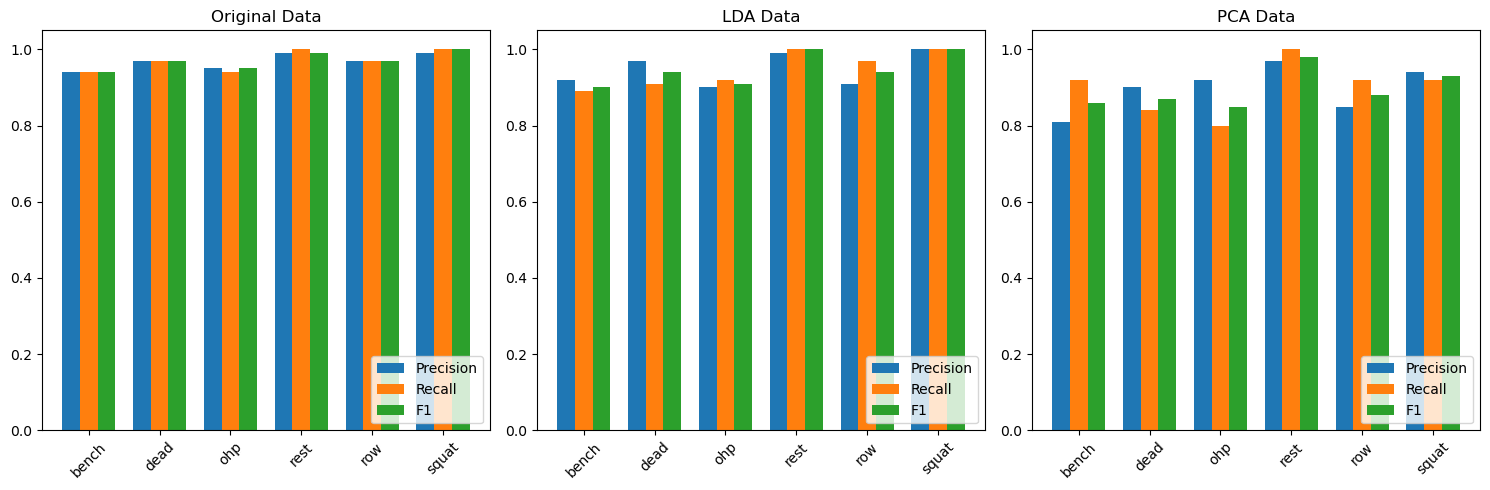

In [25]:
import matplotlib.pyplot as plt
import numpy as np

classes = ["bench","dead","ohp","rest","row","squat"]

# Original data metrics
orig_precision = [0.94, 0.97, 0.95, 0.99, 0.97, 0.99]
orig_recall    = [0.94, 0.97, 0.94, 1.00, 0.97, 1.00]
orig_f1        = [0.94, 0.97, 0.95, 0.99, 0.97, 1.00]

# LDA data metrics
lda_precision  = [0.92, 0.97, 0.90, 0.99, 0.91, 1.00]
lda_recall     = [0.89, 0.91, 0.92, 1.00, 0.97, 1.00]
lda_f1         = [0.90, 0.94, 0.91, 1.00, 0.94, 1.00]

# PCA data metrics
pca_precision  = [0.81, 0.90, 0.92, 0.97, 0.85, 0.94]
pca_recall     = [0.92, 0.84, 0.80, 1.00, 0.92, 0.92]
pca_f1         = [0.86, 0.87, 0.85, 0.98, 0.88, 0.93]

def plot_metrics(ax, precision, recall, f1, title):
    x = np.arange(len(classes))
    width = 0.25
    ax.bar(x - width, precision, width, label='Precision')
    ax.bar(x,         recall,    width, label='Recall')
    ax.bar(x + width, f1,        width, label='F1')
    ax.set_xticks(x)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_ylim([0,1.05])
    ax.set_title(title)
    ax.legend(loc='lower right')

fig, axs = plt.subplots(1, 3, figsize=(15,5), tight_layout=True)
plot_metrics(axs[0], orig_precision, orig_recall, orig_f1, "Original Data")
plot_metrics(axs[1], lda_precision, lda_recall, lda_f1, "LDA Data")
plot_metrics(axs[2], pca_precision, pca_recall, pca_f1, "PCA Data")

plt.show()

In [ ]:
df.info()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

df = pd.read_csv("../../data/partially processed/filtered_data.csv")

# 1. Separate numeric, non-numeric columns
numeric_cols = ["acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z"]
non_numeric_cols = [col for col in df.columns if col not in numeric_cols]

# 2. Normalize + PCA
X = df[numeric_cols].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

# 3. Concatenate PCA columns with non-numeric columns
df_pca = pd.concat([df[["participant", "label", "category", "set"]].reset_index(drop=True),
                    pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(4)])],
                   axis=1)
df_pca.index = df.index

# Example target (assuming 'label' is what we want to predict)
target_col = "label"

def compare_random_forest(original_df, pca_df, numeric_cols, target_col):
    # Prepare original dataset
    X_orig = original_df[numeric_cols]
    y_orig = original_df[target_col]
    
    # Prepare PCA dataset (only PCA columns as features)
    pca_columns = [col for col in pca_df.columns if col.startswith("PC")]
    X_pca = pca_df[pca_columns]
    y_pca = pca_df[target_col]
    
    # Split original
    Xo_train, Xo_test, yo_train, yo_test = train_test_split(X_orig, y_orig, test_size=0.2, random_state=42)
    # Split PCA
    Xp_train, Xp_test, yp_train, yp_test = train_test_split(X_pca, y_pca, test_size=0.2, random_state=42)
    
    # Random Forest on original
    rf_orig = RandomForestClassifier(n_estimators=50, random_state=42)
    rf_orig.fit(Xo_train, yo_train)
    orig_preds = rf_orig.predict(Xo_test)
    orig_accuracy = accuracy_score(yo_test, orig_preds)
    
    # Random Forest on PCA
    rf_pca = RandomForestClassifier(n_estimators=50, random_state=42)
    rf_pca.fit(Xp_train, yp_train)
    pca_preds = rf_pca.predict(Xp_test)
    pca_accuracy = accuracy_score(yp_test, pca_preds)
    
    print("Original data accuracy:", orig_accuracy)
    print("PCA data accuracy:", pca_accuracy)
    print(classification_report(y_test, y_pred))

print("Classification report for filtered data:")
print(classification_report(y_test_filtered, y_pred_filtered))

# 4. Compare both datasets
compare_random_forest(df, df_pca, numeric_cols, target_col)

In [5]:
def compare_random_forest(original_df, pca_df, numeric_cols, target_col):
    # Prepare original dataset
    X_orig = original_df[numeric_cols]
    y_orig = original_df[target_col]
    
    # Prepare PCA dataset (only PCA columns as features)
    pca_columns = [col for col in pca_df.columns if col.startswith("lda")]
    X_pca = pca_df[pca_columns]
    y_pca = df[target_col]
    
    # Split original
    Xo_train, Xo_test, yo_train, yo_test = train_test_split(X_orig, y_orig, test_size=0.2, random_state=42)
    # Split PCA
    Xp_train, Xp_test, yp_train, yp_test = train_test_split(X_pca, y_pca, test_size=0.2, random_state=42)
    
    # Random Forest on original
    rf_orig = RandomForestClassifier(n_estimators=50, random_state=42)
    rf_orig.fit(Xo_train, yo_train)
    orig_preds = rf_orig.predict(Xo_test)
    orig_accuracy = accuracy_score(yo_test, orig_preds)
    
    # Random Forest on PCA
    rf_pca = RandomForestClassifier(n_estimators=50, random_state=42)
    rf_pca.fit(Xp_train, yp_train)
    pca_preds = rf_pca.predict(Xp_test)
    pca_accuracy = accuracy_score(yp_test, pca_preds)
    
    print("Original data accuracy:", orig_accuracy)
    print("PCA data accuracy:", pca_accuracy)